In [1]:
import os
print(os.getcwd())


/Users/q/Code/venv/Web Mining


In [2]:
import pandas as pd

merged = pd.read_csv("2_data/sentiment_price_vix_aligned.csv", parse_dates=["created_at"])

# check col
print(merged.columns)
print(merged[["created_at", "daily_finbert"]].head())

Index(['created_at', 'daily_finbert', 'nvda_close', 'nvda_return',
       'vix_close'],
      dtype='object')
  created_at  daily_finbert
0 2022-01-04       0.135383
1 2022-01-05       0.124786
2 2022-01-06       0.127680
3 2022-01-07       0.118334
4 2022-01-10       0.125386


In [3]:
# threshold
mu = merged["daily_finbert"].mean()
sigma = merged["daily_finbert"].std()

upper = mu + 0.5*sigma     # sentiment score is higher than threshold -> buy
lower = mu - 0.5*sigma     # sentiment score is lower than threshold -> sold

print(f"avg: {mu:.4f}, sd: {sigma:.4f}")
print(f"Buy if > {upper:.4f}, Sell if < {lower:.4f}")

# transaction signal
def generate_signal(score):
    if score > upper:
        return 1    # Buy
    elif score < lower:
        return -1   # Sell
    else:
        return 0    # Hold

merged["signal"] = merged["daily_finbert"].apply(generate_signal)

print(merged[["created_at", "daily_finbert", "signal"]].head(10))


avg: 0.1175, sd: 0.0256
Buy if > 0.1303, Sell if < 0.1047
  created_at  daily_finbert  signal
0 2022-01-04       0.135383       1
1 2022-01-05       0.124786       0
2 2022-01-06       0.127680       0
3 2022-01-07       0.118334       0
4 2022-01-10       0.125386       0
5 2022-01-11       0.104899       0
6 2022-01-12       0.095698      -1
7 2022-01-13       0.096826      -1
8 2022-01-14       0.121544       0
9 2022-01-18       0.127269       0


In [4]:
# csv
merged.to_csv("sentiment_signal_full.csv", index=False)

- Visualization: signal + stock price

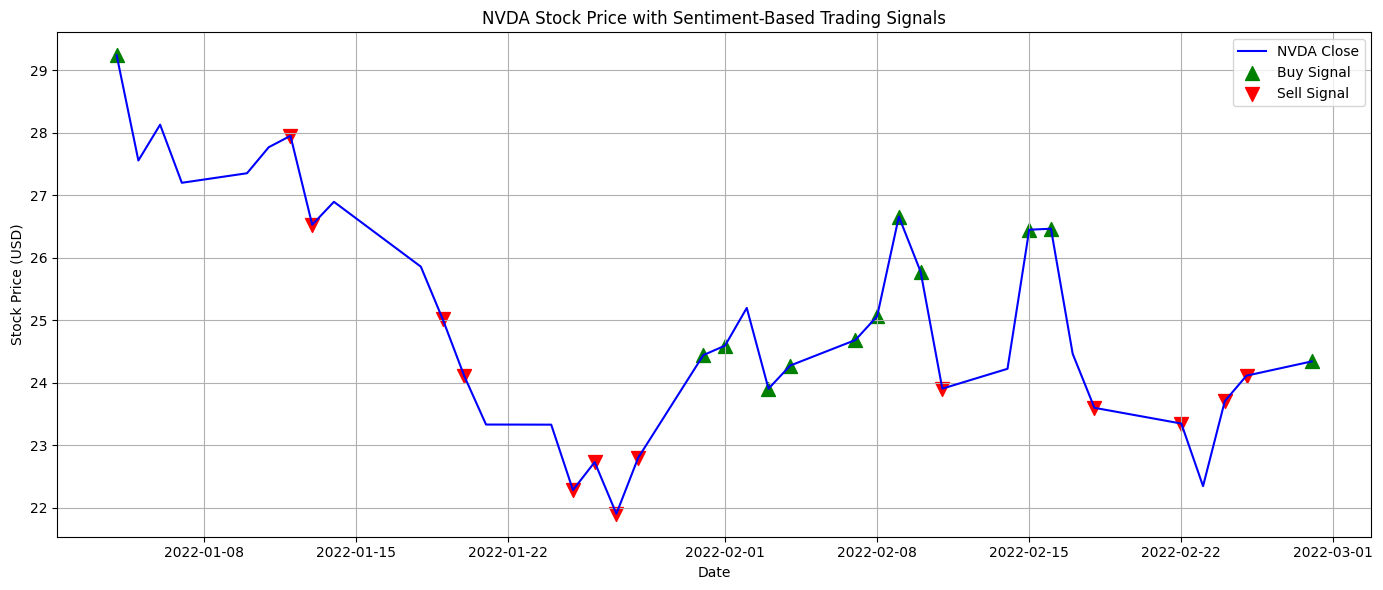

In [6]:
import matplotlib.pyplot as plt

# select buy/sell col
buy_signals = merged[merged["signal"] == 1]
sell_signals = merged[merged["signal"] == -1]

plt.figure(figsize=(14, 6))

# NVDA price movement
plt.plot(merged["created_at"], merged["nvda_close"], label="NVDA Close", color="blue")

# buy signal (green tri)
plt.scatter(buy_signals["created_at"], buy_signals["nvda_close"], 
            marker="^", color="green", label="Buy Signal", s=100)

# sell signal (red tri)
plt.scatter(sell_signals["created_at"], sell_signals["nvda_close"], 
            marker="v", color="red", label="Sell Signal", s=100)

plt.title("NVDA Stock Price with Sentiment-Based Trading Signals")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

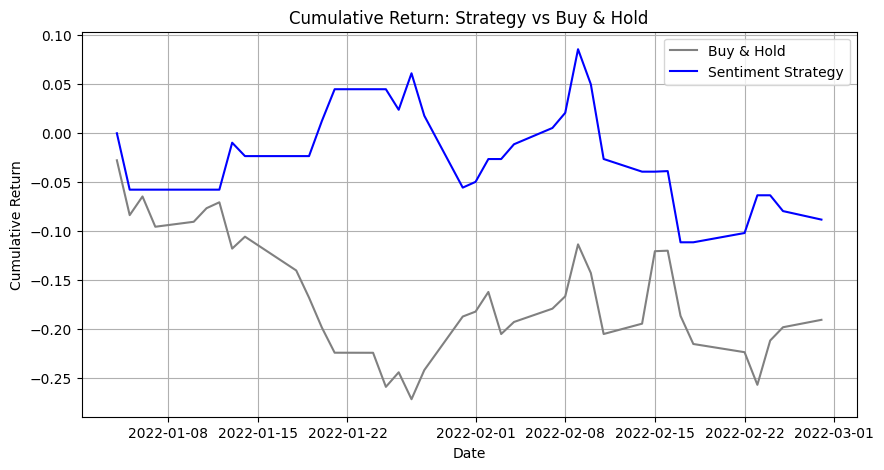

In [16]:
import numpy as np

df = merged.copy()

# move signal to +1 day
df["trade_signal"] = df["signal"].shift(1).fillna(0)

# strategy return：hold signal=1 then nvda_return，otherwise 0
df["strategy_return"] = df["trade_signal"] * df["nvda_return"]

# return
df["cum_strategy"] = (1 + df["strategy_return"]).cumprod() - 1
df["cum_bnh"]      = (1 + df["nvda_return"]).cumprod() - 1

# viz
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df["created_at"], df["cum_bnh"], label="Buy & Hold", color="gray")
plt.plot(df["created_at"], df["cum_strategy"], label="Sentiment Strategy", color="blue")
plt.title("Cumulative Return: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

- 2022-12-01 to 2022-01-01, almost match
- 2023-01-01 to 2023-02-01, not match
- WHY??

- Ensemble: modify threshold, get several different signal models, let machine to choose (like random forest)

In [8]:
# threshold modification

# 0.5×σ
upper_0_5 = mu + 0.5*sigma
lower_0_5 = mu - 0.5*sigma

# 1×σ
upper_1 = mu + 1*sigma
lower_1 = mu - 1*sigma

# 1.5×σ
upper_1_5 = mu + 1.5*sigma
lower_1_5 = mu - 1.5*sigma

# 2×σ
upper_2 = mu + 2*sigma
lower_2 = mu - 2*sigma

# model
def signal_0_5(score):
    if score > upper_0_5:
        return 1
    elif score < lower_0_5:
        return -1
    else:
        return 0

def signal_1(score):
    if score > upper_1:
        return 1
    elif score < lower_1:
        return -1
    else:
        return 0

def signal_1_5(score):
    if score > upper_1_5:
        return 1
    elif score < lower_1_5:
        return -1
    else:
        return 0

def signal_2(score):
    if score > upper_2:
        return 1
    elif score < lower_2:
        return -1
    else:
        return 0

In [9]:
# model application
merged["signal_0_5"] = merged["daily_finbert"].apply(signal_0_5)
merged["signal_1"] = merged["daily_finbert"].apply(signal_1)
merged["signal_1_5"] = merged["daily_finbert"].apply(signal_1_5)
merged["signal_2"] = merged["daily_finbert"].apply(signal_2)

In [10]:
# voting
def ensemble_signal(row):
    votes = [row["signal_0_5"], row["signal_1"], row["signal_1_5"], row["signal_2"]]
    return pd.Series(votes).mode()[0]

merged["ensemble_signal"] = merged.apply(ensemble_signal, axis=1)

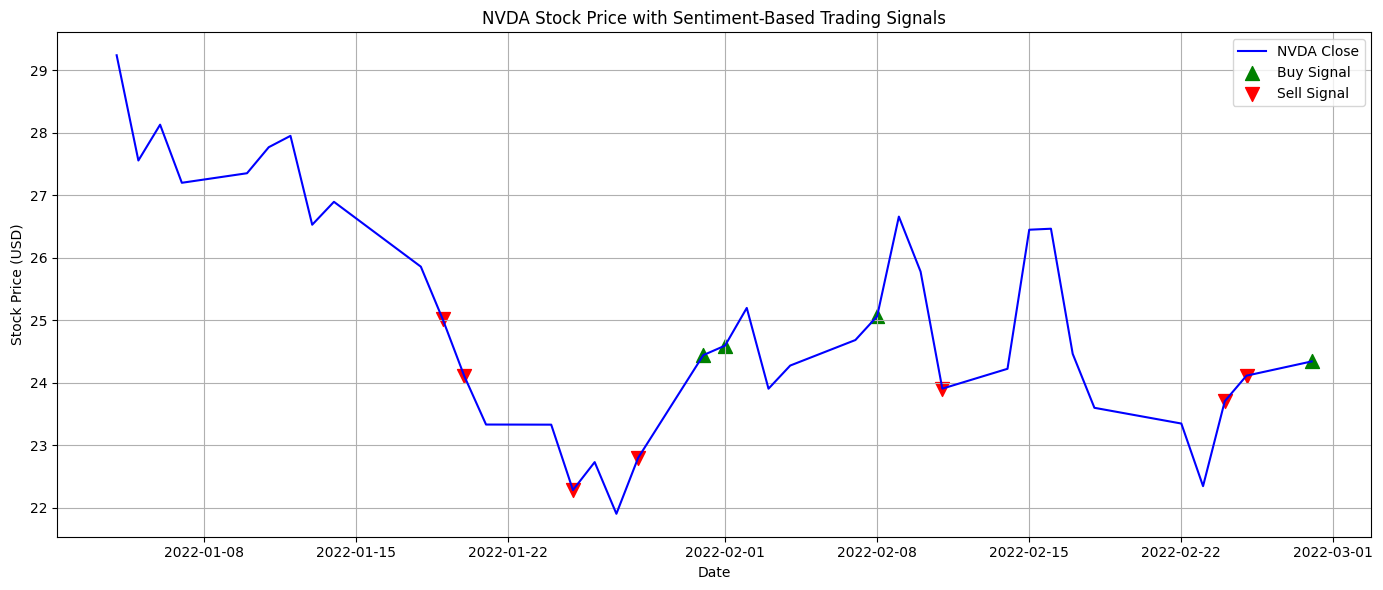

In [15]:
# pipeline
signal = merged["ensemble_signal"]

# select buy/sell col
buy_signals = merged[merged["ensemble_signal"] == 1]
sell_signals = merged[merged["ensemble_signal"] == -1]

plt.figure(figsize=(14, 6))

# NVDA price movement
plt.plot(merged["created_at"], merged["nvda_close"], label="NVDA Close", color="blue")

# buy signal (green tri)
plt.scatter(buy_signals["created_at"], buy_signals["nvda_close"], 
            marker="^", color="green", label="Buy Signal", s=100)

# sell signal (red tri)
plt.scatter(sell_signals["created_at"], sell_signals["nvda_close"], 
            marker="v", color="red", label="Sell Signal", s=100)

plt.title("NVDA Stock Price with Sentiment-Based Trading Signals")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

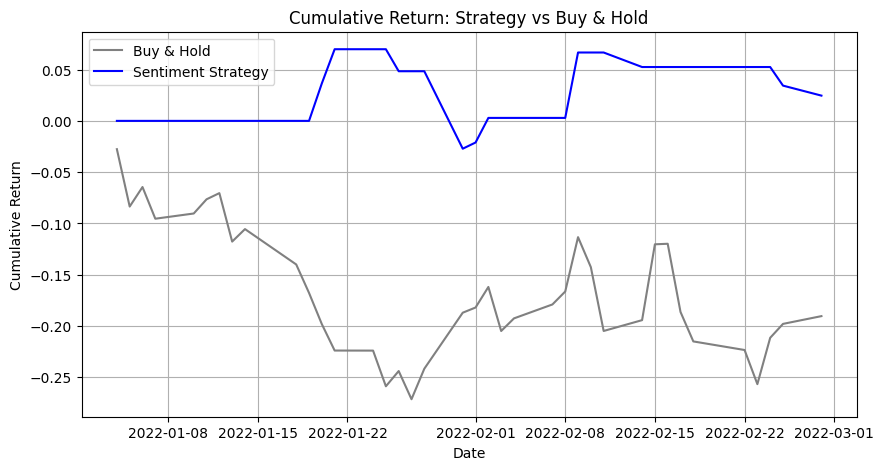

In [14]:
# pipeline
import numpy as np

df = merged.copy()

# move signal to +1 day
df["trade_signal"] = df["ensemble_signal"].shift(1).fillna(0)

# strategy return：hold signal=1 then nvda_return，otherwise 0
df["strategy_return"] = df["trade_signal"] * df["nvda_return"]

# return
df["cum_strategy"] = (1 + df["strategy_return"]).cumprod() - 1
df["cum_bnh"]      = (1 + df["nvda_return"]).cumprod() - 1

# viz
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df["created_at"], df["cum_bnh"], label="Buy & Hold", color="gray")
plt.plot(df["created_at"], df["cum_strategy"], label="Sentiment Strategy", color="blue")
plt.title("Cumulative Return: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()